# Alcoy Tourist

## Introducción

Para poder lograr definir al municipio de Alcoi como Municipio Turístico es necesario averiguar la afluencia de turistas que visitan Alcoy, estas estadísticas se consiguen en Alcoi mediente la obtención de redes favoritas los teléfonos que diariamente transitan por las calles de Alcoi. De esta manera se obtiene una relación de los residentes y turistas de Alcoi que se puede verificar en el `Decreto de Municipio Turístico 2020`. El objetivo general de este proyecto es realizar un análisis sobre los datos turísticos de la ciudad de Alcoy. 


A la hora de realizar este análisis, disponemos de los siguientes objetivos secundadrios:

- Detectar turistas que llegan a Alcoy gracias a un sistema inteligente.
- Evaluar el rendimiento del sistema comparando los turistas detectados respecto a los turistas de los que se tienen datos.
- Análisis mensual de la cantidad de turistas.
- Descubrimiento de conocimiento en base a datos de las encuestas.

El sistema inteligente dispone de información relativa a los dispositivos conectados a la red que se encuentran en la ciudad de Alcoy (pudiéndose considerar como routers). Además, es capaz de rastrear los puntos de conexión favoritos de los dispositivos personales de los viandantes (se pueden considerar como teléfonos móviles) siempre y cuando éstos tengan el WiFi activado.

Para lograr los objetivos de ese proyecto se dispone de tres conjuntos de datos:
- `datosEncuesta2206`: se trata de encuestas que se han realizado a las personas que han accedido a las oficinas de turismo y aportan información útil para el análisis. Los campos de este conjunto de datos son: la fecha de la visita, lugar de residencia, número de acompañantes y si tienen el wifi activado o no. Consta de los siguientes campos:
    - **Marca temporal**: Campo de tipo `datetime` cuyo propósito es almacenar la fecha y hora en la que fué registrado la entrada en la oficina de turismo.
    - **¿Cúal es su lugar de residencia?**: Campo de tipo texto que almacena el lugar donde reside la persona.
    - **En el caso de que haya marcado anteriormente que su lugar de residencia NO es Alcoi. ¿Podría especificar de dónde es? (país, provincia, municipio...)**: Entrada de tipo texto que tiene como propósito ampliar el campo anterior.
    - **¿Con cuántas personas viaja?**: Campo tipo numérico que especifica el número de personas que conforman el grupo que visita Alcoi.
    - **¿Con cuántas personas de las que viaja han entrado a las Tourist-Info?**: Campo tipo numérico que indica la cantidad de personas dentro del grupo que también han ingresado a `Tourist Info`.
- `datosSensorTurismo2206`: contiene la información de las conexiones de los dispositivos móviles rastreados (MAC) a un punto de acceso (SSID).
    - **date**: Campo tipo numérico en formato `Unix` que es la marca de tiempo en la que se registró la obtención de los datos.
    - **mac**: Identificador del dispositivo del que se tomaron los datos en formato alfanumérico.
    - **ssid**: Identificador `ssid` de los ultimos dispositivos a los que el `mac` ha tenido acceso. En formato alfanumérico.
- `ssidsAlcoi`: un listado con todas las SSIDS rastreadas de Alcoy.
    - **ssid**: Listado de los `ssid` de Alcoi, formato alfanumérico.


Hay que tener en cuenta que el objetivo de este proyecto no es sencillo, no todos los visitantes tienen activado el Wifi de su teléfono. Por lo que no se pueden la detección de estos turistas por el sistema.

El objetivo de este proyecto es:


Este objetivo no es sencillo porque no todos los visitantes tienen activado el Wifi de su teléfono....

Para lograr este objetivo analizaremos.....

In [635]:
# !pip install mplfinance
# !pip install chart_studio
# !pip install cufflinks

# Imports

In [636]:
import sweetviz as sv
import pandas as pd
from datetime import datetime
from collections import Counter
import sklearn.metrics as metrics
import plotly.express as px
import statsmodels.api as sm
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from matplotlib import dates
import matplotlib.pyplot as plt
import mplfinance as mpf
import statsmodels.api as sm
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

from statsmodels.tsa.seasonal import seasonal_decompose

pd.options.plotting.backend = "plotly"

# Data

## Paths definition

Se definirán la ruta desde la que se cargarán los datos, así como la ruta donde se guardarán los reportes generados por `Sweetviz`.

In [637]:
DATA_PATH = 'data'
REPORTS_PATH = 'reports/'

## Data loading

En este proyecto dispondremos de tres dataset:

- `datosEncuesta2206`: contiene la información relativa a las encuestas realizadas a las personas que han visitado la oficina de turismo de Alcoy.
- `datosSensorTurismo2206`: dispone de información correspondientes a los 5 SSIDs favoritos de los moviles de las personas.
- `ssidsAlcoi`: este dataset contiene el SSiDs de los dispositivos como routers, de Alcoi, estos fueron recolectados y resistrados, a partir de estos datos se realizan los  filtros de los datos del sensor de turismo.

Nota: _En el conjunto de datos datos SSIDS Alcoi tenemos todas las direcciones de los puntos de conexión de la ciudad de Alocai._


In [638]:
quiz_df = pd.read_csv(f"{DATA_PATH}/datosEncuesta2206.csv")
sensor_df = pd.read_csv(f"{DATA_PATH}/datosSensorTurismo2206.csv")
ssids_df  = pd.read_csv(f"{DATA_PATH}/ssidsAlcoi.csv")

# Analyisis

In [639]:
# quiz_report = sv.analyze(quiz_df)
# quiz_report.show_html(f"{REPORTS_PATH}/Quiz.html")

# sensor_report = sv.analyze(sensor_df)
# sensor_report.show_html(f"{REPORTS_PATH}/Sensors.html")

# ssids_report = sv.analyze(ssids_df)
# ssids_report.show_html(f"{REPORTS_PATH}/SSIDs.html")

A continuación listaremos todos los dispositivos que se han conectado a alguna de las redes conocidas en Alcoy, junto a la MAC del dispositivo, se mostrará el número de veces que se ha conectado a algún router (sea o no de Alcoi) desde que se empezó a recoger esta información por el sistema.

In [640]:
sorted_macs_ssid = sensor_df.groupby(by=["mac", 'ssid']).count().sort_values('date', ascending = False)
sorted_macs_ssid

,,date
mac,ssid,
d29675014f618f3ef3f6b75f146b4be71c513c16,cca78a1e963f3ba3443bf3e54a9aa939f73d223d,12807
5cbcffeab5fa9206a8c2712ef085daab688dd086,cca78a1e963f3ba3443bf3e54a9aa939f73d223d,1267
273a50bed34ca35e5d1987ea3b05ce765aae0e0e,917c1e46b3861300aebf9a14e47a6ec989c7ac9e,933
6ec65bc349733bc0e85d17294d3a9cb6d8b8bdc8,ffd2edd79fe4bac98610a2ad6892b53395e44e34,724
de6157c0185924febf402efa9e4c36a4cbe4cbb1,cca78a1e963f3ba3443bf3e54a9aa939f73d223d,496
...,...,...
57502713dc0b287ab0e893c8313f55598077630f,7a592c4a3d20f50b2ba09a85b67c6d2fc925664b,1
5751a0c6507a8accd8a13005b6976d663db69bad,7a592c4a3d20f50b2ba09a85b67c6d2fc925664b,1
575588aec3617b91ea18facfd1e52a939b47dd6f,b67ede98966e4c418becb185d7efc74e2f59aa15,1


In [641]:
sensor_df.sort_values('date', ascending = False)


,date,mac,ssid
41670,1651557308022,adb3077264a1cdaebd3f000e5106b938b686d5ba,7a592c4a3d20f50b2ba09a85b67c6d2fc925664b
41669,1651557247963,9d164cc8432ebbec973b72d0863104278159d59e,7a592c4a3d20f50b2ba09a85b67c6d2fc925664b
41668,1651517743891,68cdd2558ab66ae552181a6a1020d761b6070884,877a09473e70b0032058eedab1ac679086a2ad84
41667,1651517623913,16e6a88f3a1690cc46ea76f103b9ca50f2348623,877a09473e70b0032058eedab1ac679086a2ad84
41666,1651517503850,0d47b0ba9ff0d21c53891dd51d915db490c5d6cd,877a09473e70b0032058eedab1ac679086a2ad84
...,...,...,...
4,1624342199096,d29675014f618f3ef3f6b75f146b4be71c513c16,cca78a1e963f3ba3443bf3e54a9aa939f73d223d
3,1624342180676,5cbcffeab5fa9206a8c2712ef085daab688dd086,cca78a1e963f3ba3443bf3e54a9aa939f73d223d
2,1624342133875,d29675014f618f3ef3f6b75f146b4be71c513c16,cca78a1e963f3ba3443bf3e54a9aa939f73d223d
1,1624342089379,5cbcffeab5fa9206a8c2712ef085daab688dd086,cca78a1e963f3ba3443bf3e54a9aa939f73d223d


Tal como se explica en la web **REFERENCIA DE ABAJO**, se considerarán turistas aquellas personas cuya red favorita en su teléfono no sea de una de Alcoy. Para esto se realizará un conteo del número de veces que cada dispositvo se ha conectado a alguna red (siendo de Alcoy o no), de esta forma se podrá analizar cual es la favorita para cada dispositivo, y, posteriormente, se filtrarán aquellas conexiones cuyo punto de acceso (routers) no sea de Alcoy para considerarlos turistas.

In [642]:
# Se eliminar los identificadores de los routers que se encuentran duplicados.
ssids_df = ssids_df.drop_duplicates()
sorted_macs = sensor_df.groupby(by=["mac", "ssid"]).count().sort_values('date', ascending = False)
sorted_macs

,,date
mac,ssid,
d29675014f618f3ef3f6b75f146b4be71c513c16,cca78a1e963f3ba3443bf3e54a9aa939f73d223d,12807
5cbcffeab5fa9206a8c2712ef085daab688dd086,cca78a1e963f3ba3443bf3e54a9aa939f73d223d,1267
273a50bed34ca35e5d1987ea3b05ce765aae0e0e,917c1e46b3861300aebf9a14e47a6ec989c7ac9e,933
6ec65bc349733bc0e85d17294d3a9cb6d8b8bdc8,ffd2edd79fe4bac98610a2ad6892b53395e44e34,724
de6157c0185924febf402efa9e4c36a4cbe4cbb1,cca78a1e963f3ba3443bf3e54a9aa939f73d223d,496
...,...,...
57502713dc0b287ab0e893c8313f55598077630f,7a592c4a3d20f50b2ba09a85b67c6d2fc925664b,1
5751a0c6507a8accd8a13005b6976d663db69bad,7a592c4a3d20f50b2ba09a85b67c6d2fc925664b,1
575588aec3617b91ea18facfd1e52a939b47dd6f,b67ede98966e4c418becb185d7efc74e2f59aa15,1


El siguiente paso será obtener la red favorita de cada dispositivo, obteniendo aquella conexión que más veces se ha producido desde un dispositivo a un SSID:

In [643]:
# Agrupamos el dataframe por mac y por ssid, haciendo un conteo para visualizar
# el nº de veces que un dispositivo se ha conectado a una ssid en concreto.
sorted_macs = sensor_df.groupby(by=["mac", "ssid"])['date'].count().reset_index(name="connections").sort_values('connections', ascending = False)

# Haciendo un group by por mac, obtenemos el id del registro de aquellos conteos máximos, es decir,
# para cada dispositivo calculamos el valor máximo (máximo número de conexiones a las redes) y obtenemos
# su id para después poder referenciar el dispositivo y la red que ha tenido más conexiones por su parte.
idx_max_macs = sorted_macs.groupby(['mac'])['connections'].idxmax()

# Obtenemos los registros en base a los índices calculados anteriormente y ordenamos de forma descendente.
sorted_macs  = sorted_macs.loc[idx_max_macs].sort_values('connections', ascending = False)

sorted_macs

,mac,ssid,connections
15559,d29675014f618f3ef3f6b75f146b4be71c513c16,cca78a1e963f3ba3443bf3e54a9aa939f73d223d,12807
6917,5cbcffeab5fa9206a8c2712ef085daab688dd086,cca78a1e963f3ba3443bf3e54a9aa939f73d223d,1267
2946,273a50bed34ca35e5d1987ea3b05ce765aae0e0e,917c1e46b3861300aebf9a14e47a6ec989c7ac9e,933
8270,6ec65bc349733bc0e85d17294d3a9cb6d8b8bdc8,ffd2edd79fe4bac98610a2ad6892b53395e44e34,724
16403,de6157c0185924febf402efa9e4c36a4cbe4cbb1,cca78a1e963f3ba3443bf3e54a9aa939f73d223d,496
...,...,...,...
6494,575905f14f00a35cd78292cca34d247285dba5e9,ca5a36444b047eb95e491fa2e70f968ae048ab10,1
6495,575a15e5ce9c7d65094333b9414cfcee1f49b9e9,5481655e85d7b477c2b37270be825fab0638e137,1
6496,575b3cf0642ac6ed9893dc02a0e541aef93183e2,79b10e6c830d5c4d8ef7ac53ac685df439ad6f23,1
6497,575e5b90c000c38c665a032eb1dca6805119a866,7a592c4a3d20f50b2ba09a85b67c6d2fc925664b,1


In [644]:
# Routers únicos a los que se han conectado los dispositivos alguna vez
print(f'Routers únicos a los que se han conectado los dispositivos alguna vez: {len(sorted_macs.ssid.unique())}')
# Routers únicos total registrados por el camión de basura (total ciudad).
print(f'Routers únicos total registrados por el camión de basura (total ciudad): {len(ssids_df.ssid.unique())}')

# Existen muchos más routers detectados por el camión que puntos de acceso únicos a los que se conectan los móviles.

Routers únicos a los que se han conectado los dispositivos alguna vez: 1004
Routers únicos total registrados por el camión de basura (total ciudad): 34259


Como la conexión favorita de los dispositivos no debe ser de Alcoy, eliminaremos aquellos dispositivos cuya conexión favorita sabemos que es de Alcoy.

In [645]:
sorted_macs = sorted_macs[~sorted_macs.ssid.isin(ssids_df.ssid)]
sorted_macs

,mac,ssid,connections
8270,6ec65bc349733bc0e85d17294d3a9cb6d8b8bdc8,ffd2edd79fe4bac98610a2ad6892b53395e44e34,724
14608,c5cf42dbeeeec2c87097c74cb45c72343b70f5a5,ca5a36444b047eb95e491fa2e70f968ae048ab10,105
17411,ec4931e131e3ffbabb54c05249f97db9f0684c93,ffd2edd79fe4bac98610a2ad6892b53395e44e34,100
2886,2645ffe542737dd58232ebd8eab47245ebd631ce,cfaeaac13a5e3e68077133a0886eea13760f146f,76
9173,7b535408d7c0ada32bca60984ffb653ae4100708,bcdb505c4bee05b51423fdce27786e07fa7af46d,75
...,...,...,...
6489,57458c53b83c7ad8b7afbcf00b89559ae053d70c,2aa3b84471cfaa3ab3ec92df5cc92f56617bec59,1
6493,575588aec3617b91ea18facfd1e52a939b47dd6f,b67ede98966e4c418becb185d7efc74e2f59aa15,1
6494,575905f14f00a35cd78292cca34d247285dba5e9,ca5a36444b047eb95e491fa2e70f968ae048ab10,1
6495,575a15e5ce9c7d65094333b9414cfcee1f49b9e9,5481655e85d7b477c2b37270be825fab0638e137,1


## Quiz Analysis

In [646]:
COLUMNS_RENAMED = ['date', 'residence_1', 'residence_2', 'companions_number', 'companions_visited_info_office', 'wifi_enabled']

quiz_df.columns = COLUMNS_RENAMED
quiz_df['date'] = pd.to_datetime(quiz_df['date'], infer_datetime_format = True)
quiz_df['residence_2'] = quiz_df['residence_2'].str.strip()

quiz_df

C:\ProgramData\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning:

tzname EET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.



,date,residence_1,residence_2,companions_number,companions_visited_info_office,wifi_enabled
0,2021-06-22 10:05:40,Alcoi,NaN,2,2,No entiendo la pregunta
1,2021-06-22 10:58:33,España,Madrid,0,0,No
2,2021-06-23 10:13:42,Alcoi,NaN,0,0,Sí
3,2021-06-23 10:14:04,España,Amposta,1,1,Sí
4,2021-06-23 10:46:55,Internacional,Belgica,1,1,Sí
...,...,...,...,...,...,...
2592,2022-02-28 17:11:25,Internacional,Francia,4,4,Sí
2593,2022-02-28 17:46:35,Comunidad Valenciana,Torreviaje,1,1,No
2594,2022-02-28 18:21:35,Internacional,Chile,0,0,No
2595,2022-02-28 18:22:04,Alcoi,NaN,2,2,Sí


Se muestra un histograma de la procedencia de los turistas que han rellenado la encuesta de las oficinas de turismo:

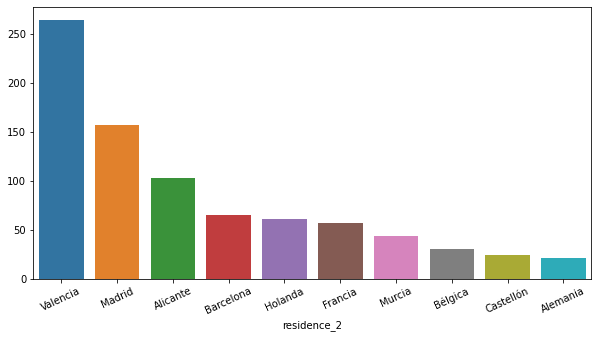

In [647]:
import seaborn as sns
import matplotlib.pyplot as plt

top_visitor_places = quiz_df.groupby(['residence_2'])['residence_2'].count().sort_values(ascending = False)
plt.figure(figsize=(10, 5))
histogram = sns.barplot(x = top_visitor_places[:10].index,
                        y = top_visitor_places[:10].values)
histogram.tick_params(axis='x', rotation=25)

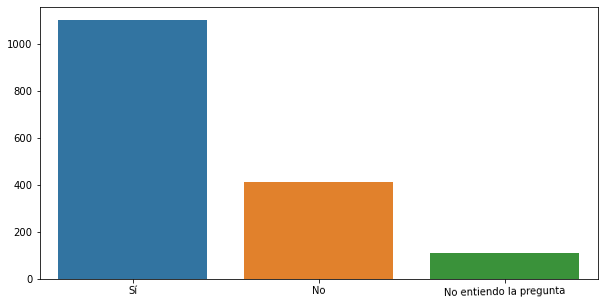

In [648]:
tourist_wifi_enabled = quiz_df[quiz_df['residence_1'] != 'Alcoi']['wifi_enabled'].value_counts()

plt.figure(figsize=(10, 5))
histogram = sns.barplot(x = tourist_wifi_enabled.index,
                        y = tourist_wifi_enabled.values)

histogram.tick_params(axis='x', rotation = 1)

Ciñéndonos a los turistas que son conscientes de que han activado el wifi, con el sistema implantado se estaría capturando aproximadamente el 47% de los turistas totales que visitan la ciudad.

In [649]:
quiz_df['date'] = quiz_df['date'].dt.strftime('%Y-%m')
single_tourist_info_visitors = quiz_df.loc[quiz_df.index.repeat(quiz_df.companions_number)]
tourist_info_visitors = single_tourist_info_visitors.groupby(by = ['date'])['residence_1'].count()

## Time Series Analysis

Obtenemos un total de 10.876 dispositivos cuya red favorita no es de Alcoy, por lo tanto los podemos considerar como turistas.

En el siguiente apartado convertimos a formato de fecha y renombramos las columnas de `quiz_df`, esto es necesario para realizar otro análisis de los datos que nos permitirá comparar las estadíticas extraidas de la oficina de `Tourist Info` y los datos recolectados por los `Hopus`.

In [650]:
COLUMNS_RENAMED = ['date', 'residence_1', 'residence_2', 'companions_number', 'companions_visited_info_office', 'wifi_enabled']


quiz_df.columns = COLUMNS_RENAMED
quiz_df['date'] = pd.to_datetime(quiz_df['date'], infer_datetime_format = True)
quiz_df['residence_2'] = quiz_df['residence_2'].str.strip()

- Convertimos el campo `date` de `quiz_df` en formato de `YYYY-mm` para poder hacer las agrupaciones de los turistas por mes.
- Copiamos los datos del dataframe y lo agrupamos por fecha, esto nos permite tener el conteo de de turistas por mes, renombramos las nuevas columnas.


In [651]:
quiz_df['date'] = quiz_df['date'].dt.strftime('%Y-%m')
single_tourist_info_visitors = quiz_df.loc[quiz_df.index.repeat(quiz_df.companions_number)]
tourist_info_visitors = single_tourist_info_visitors.groupby(by = ['date'])['residence_1'].count()
tourist_info_visitors = tourist_info_visitors.to_frame()
tourist_info_visitors['tourist_info'] = 'Oficina de Turismo' 
tourist_info_visitors.columns = ['count', 'tourist_info']

En el siguiente apartado, realizamos una copia de los datos extraidos de los teléfonos móviles mediante el uso de `Hopus` que son los dispositivos que se enecuentran ubicados en puntos estratégicos de Alcoi. Estos dispositivos se encargan de captar los `SSIDs` y los `MAC Address` de los dispositivos moviles que pasan por las zonas estratégicas de **Alcoi**.

> Convertimos el campo `date` que se encuentra en formato `Unix Epoch Ms` a `datetime`, de esta extracción agruparemos por año y mes para poder contar el número de turistas que llegan a la ciudad. El dataframe `temporal_analysis_df` ha sido filtrado por los `MAC Address` y `SSIDs` de los dispositivos moviles que fueron prefiltrados y seleccionados como turistas.  

In [652]:
temporal_analysis_df = sensor_df.copy()

temporal_analysis_df = temporal_analysis_df[(temporal_analysis_df.ssid.isin(sorted_macs.ssid)) & (temporal_analysis_df.mac.isin(sorted_macs.mac))]

# Solo extraemos la fecha para poder hacer el análisis temporal.
temporal_analysis_df['date'] = pd.to_datetime(temporal_analysis_df['date'], unit='ms').dt.date
temporal_analysis_df['date'] = pd.to_datetime(temporal_analysis_df['date'])
temporal_analysis_df['date'] = temporal_analysis_df['date'].dt.strftime('%Y-%m')

time_series = temporal_analysis_df.groupby(by=["date"])['mac'].count()
time_series = time_series.to_frame()
time_series['tourist_info'] = 'Hopus'
time_series.columns = ['count', 'tourist_info']

Concatenamos los dos dataset para poder hacer el análsis de las series temporales.

In [653]:
frames = [time_series, tourist_info_visitors]

result = pd.concat(frames)

result.reset_index(inplace=True)
result = result.rename(columns = {'index':'date'})

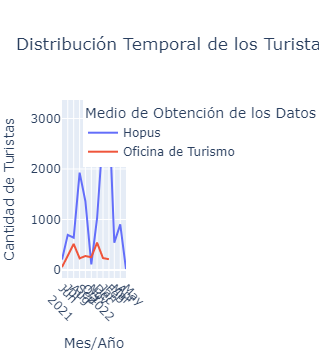

In [654]:
fig = px.line(result, x='date', y='count', color='tourist_info', 
                labels={
                 "count": "Cantidad de Turistas",
                 "date": "Mes/Año",
                 "tourist_info": "Medio de Obtención de los Datos"
                },
              title='Distribución Temporal de los Turistas en Alcoi')
fig.update_xaxes(tickangle=45, 
                dtick="M1",
                tickformat="%b\n%Y")
fig.show()

- Podemos observar que de los datos recolectados del `Hopus` estos representan una mayor proporción comparados a los recolectados por la oficina de `Tourist Info`, esto es un indicador de como menciona el artículo de referencia, las personas más y más se informan mediante internet antes de visitar lugares turísticos.

- Menos y menos turistas acuden a las oficnas de información turistica para poder informarse.

# Time Series Prediction

En el siguiente apartado intentaremos aplicar téçnicas de análisis de series temporales para aproximar la cantidad de turistas en fechas futuras.

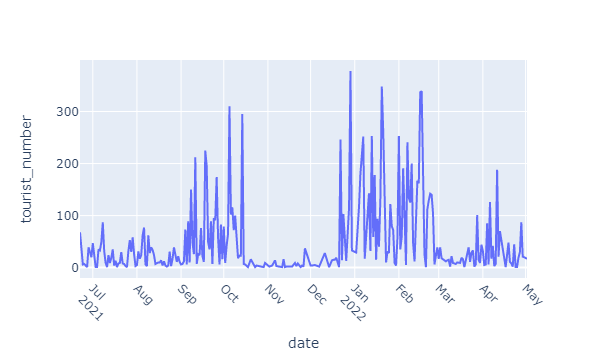

In [655]:
temporal_series_df = sensor_df.copy()

temporal_series_df = temporal_series_df[(temporal_series_df.ssid.isin(sorted_macs.ssid)) & (temporal_series_df.mac.isin(sorted_macs.mac))]

# Solo extraemos la fecha para poder hacer el análisis temporal.
temporal_series_df['date'] = pd.to_datetime(temporal_series_df['date'], unit='ms').dt.date
temporal_series_df['date'] = pd.to_datetime(temporal_series_df['date'])


time_series = temporal_series_df.groupby(by=["date"])['mac'].count()
time_series = time_series.to_frame()
time_series.reset_index(inplace=True)
time_series = time_series.rename(columns = {'mac':'tourist_number'})

fig = px.line(time_series, x="date", y="tourist_number")
fig.update_xaxes(tickangle=45, 
                dtick="M1",
                tickformat="%b\n%Y")
fig.show()

Utilizamos `statmodels` para realizar la estimación de series temporales y poder elaborar un modelo que sea capaz de aproximar la cantidad de turistas que se pueden recibir. 

> **Observación:** Este modelo puede ser demasiado impreciso debido a el proyecto de recolección del `SSIDs` empezó a funcionar en 2021, justo después de la pandemia, durante este tiempo la afluencia normal de turistas puede ser relativamente menor a la comparada con periodos anteriores a la pandemia. por este motivo se recomienda actualizar con frecuencia este modelo cada mes.  


In [656]:
time_series.set_index('date', inplace=True)
time_series.sort_index(inplace=True)

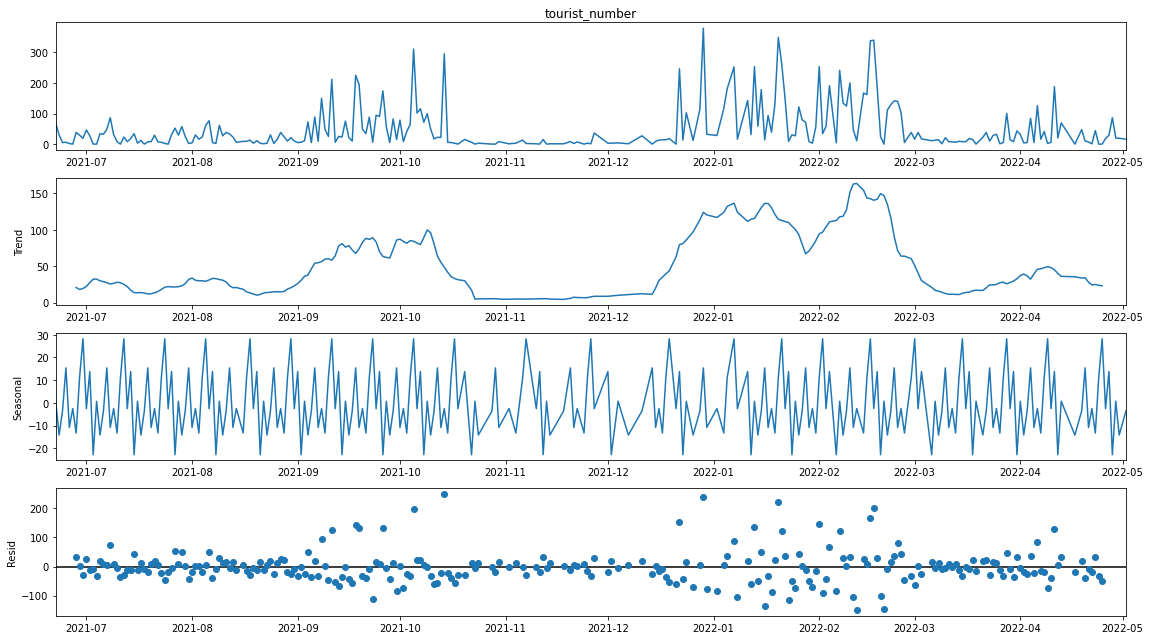

In [657]:

sd = seasonal_decompose(time_series['tourist_number'] ,model='additive', period=12)

fig = sd.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

In [658]:

time_series['tourist_number'] = time_series['tourist_number']

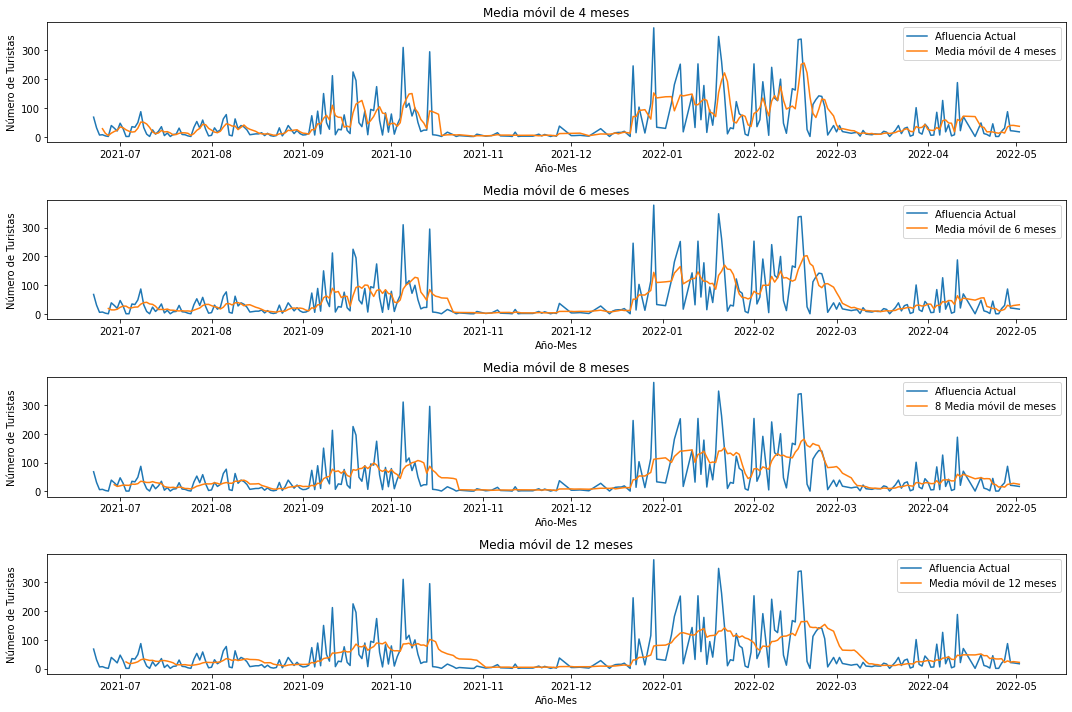

In [659]:

fig,axes = plt.subplots(4)
fig.set_figheight(10)
fig.set_figwidth(15)
axes[0].plot(time_series.index,time_series['tourist_number'],label='Afluencia Actual')
axes[0].plot(time_series.index,time_series['tourist_number'].rolling(window=4).mean(),label='Media móvil de 4 meses')
axes[0].set_xlabel('Año-Mes')
axes[0].set_ylabel('Número de Turistas')
axes[0].set_title('Media móvil de 4 meses')
axes[0].legend(loc='best')


axes[1].plot(time_series.index,time_series['tourist_number'],label='Afluencia Actual')
axes[1].plot(time_series.index,time_series['tourist_number'].rolling(window=6).mean(),label='Media móvil de 6 meses')
axes[1].set_xlabel('Año-Mes')
axes[1].set_ylabel('Número de Turistas')
axes[1].set_title('Media móvil de 6 meses')
axes[1].legend(loc='best')



axes[2].plot(time_series.index,time_series['tourist_number'],label='Afluencia Actual')
axes[2].plot(time_series.index,time_series['tourist_number'].rolling(window=8).mean(),label='8 Media móvil de meses')
axes[2].set_xlabel('Año-Mes')
axes[2].set_ylabel('Número de Turistas')
axes[2].set_title('Media móvil de 8 meses')
axes[2].legend(loc='best')


axes[3].plot(time_series.index,time_series['tourist_number'],label='Afluencia Actual')
axes[3].plot(time_series.index,time_series['tourist_number'].rolling(window=12).mean(),label='Media móvil de 12 meses')
axes[3].set_xlabel('Año-Mes')
axes[3].set_ylabel('Número de Turistas')
axes[3].set_title('Media móvil de 12 meses')
axes[3].legend(loc='best')

plt.tight_layout()
plt.show()

En las graficas anteriores miramos la media movil de la distribución de los turistas captados por el dispositivo `Hopus`.

> La media movil es un cálculo que utilizamos para analizar un conjunto de datos en modo de puntos para crear una serie de promedios. De esta manera podemos tener una estimación basada del conjunto de lso datos originales.

Esto nos sirve para calcular una serie temporal con demanda estable, que no tiene tendencia ni estacionalidad, como es el caso de la afluencia de turistas en Alcoi.

## Tourist Flow

Se mostrará una representación de las dimensiones de las encuestas par a par, con el objetivo de encontrar correlaciones y patrones en los comportamientos en función de las variables del conjunto de datos.

<Figure size 2160x1440 with 0 Axes>

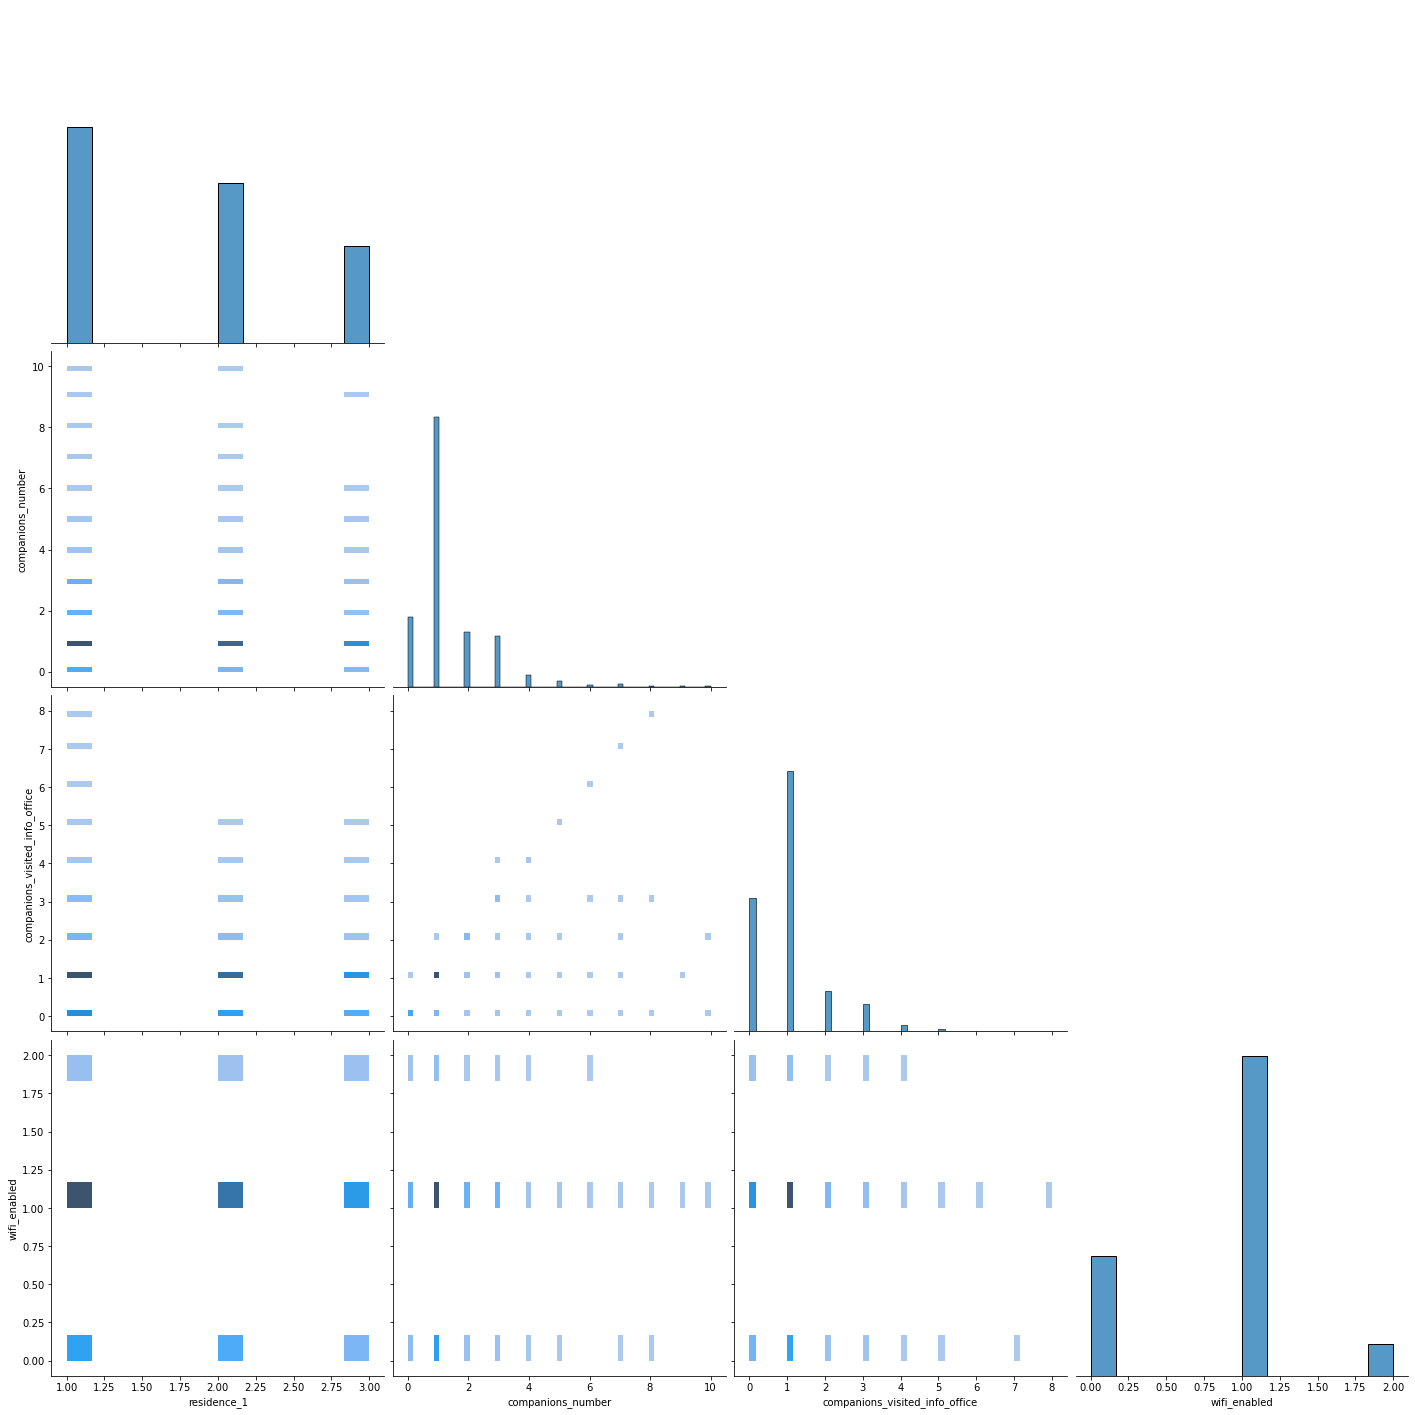

In [660]:
wifi_replace = {'No': 0,
                'Sí': 1,
                'No entiendo la pregunta': 2
               }
residence_replace = {'Alcoi': 0,
                     'Comunidad Valenciana': 1,
                     'España': 2,
                     'Internacional': 3
                   }
quiz_aux_df = quiz_df.copy()
quiz_aux_df['wifi_enabled'].replace(wifi_replace, inplace = True)
quiz_aux_df['residence_1'].replace(residence_replace, inplace = True)

quiz_aux_df = quiz_aux_df[quiz_aux_df['residence_1'] != 0]

plt.figure(figsize=(30, 20))
sns.pairplot(quiz_aux_df, kind="hist", corner = True, height = 5)

Analizando la gráfica de lugar de residencia y número de personas que acompañan al turista se observa que hay una de las localidades que contiene valores más altos para el número de acompañantes. En la siguiente gráfica se mostrará la distribución de acompañantes en función de la región origen de los turistas:

<AxesSubplot:xlabel='companions_number', ylabel='Count'>

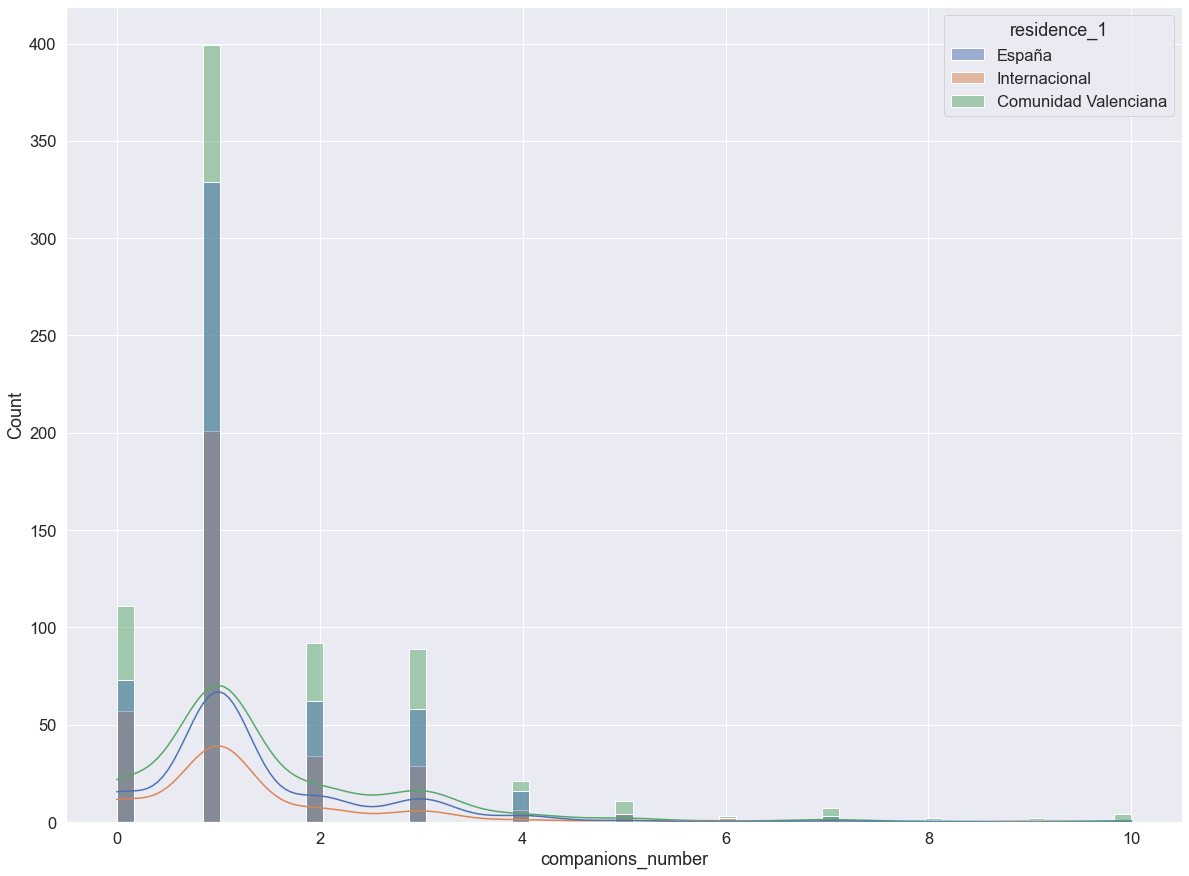

In [661]:
aux = quiz_df[quiz_df['residence_1'] != 'Alcoi']

sns.set(font_scale = 1.5)
plt.figure(figsize=(20,15))
sns.histplot(data=aux, x="companions_number", hue="residence_1", kde=True)

Se observa que los turistas de la comunidad valenciana suelen venir acompañados en grupos de hasta 10 personas mucho más frecuentemente que de turistas de origen internacional y nacional. Incluso en los grupos de cuatro personas, proporcionalmente. 

<AxesSubplot:xlabel='companions_number', ylabel='Count'>

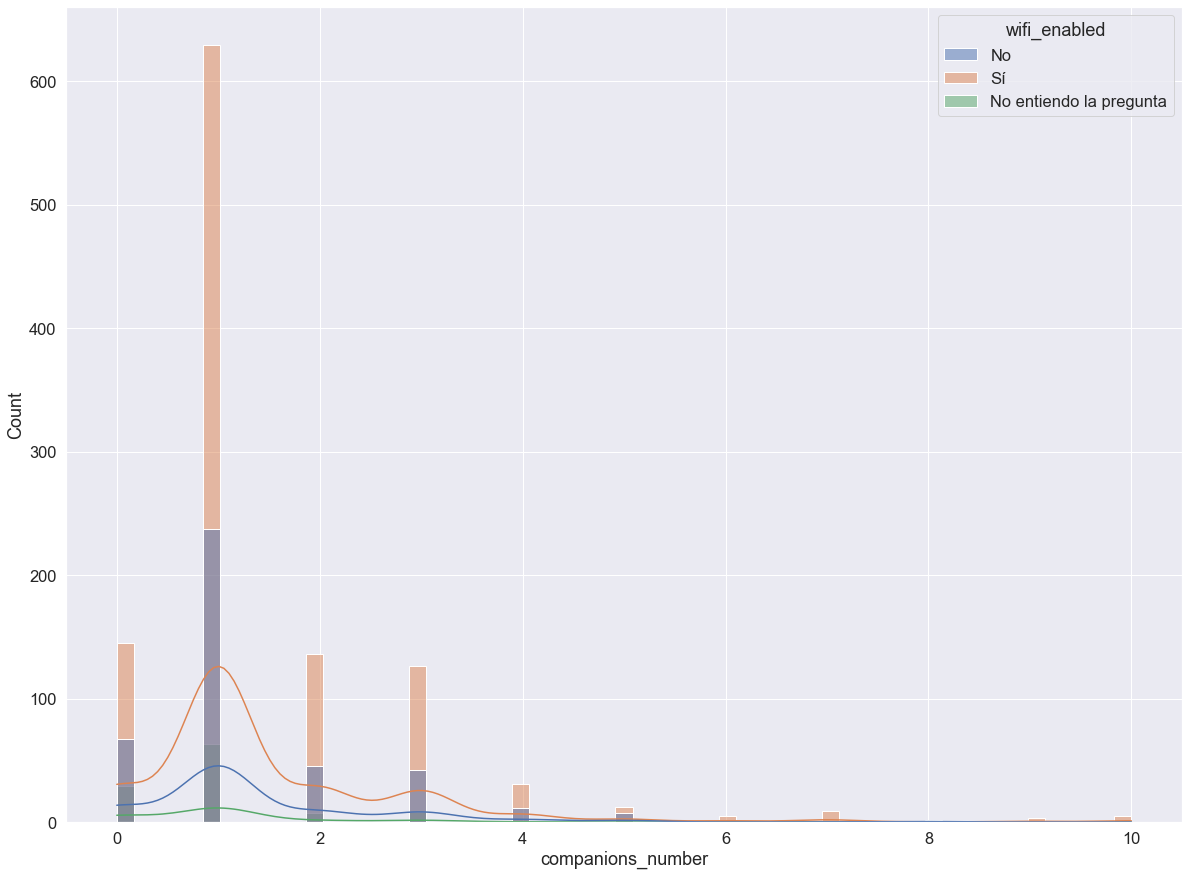

In [662]:
# Comparativa acompañantes/acompañantes-oficina - Wifi
# fig, axes = plt.subplots(1, 2, figsize=(30,15))
# sns.set(font_scale = 1.5)
# sns.histplot(ax=axes[0], data=aux, x="companions_number", hue="wifi_enabled", kde=True)
# sns.histplot(ax=axes[1], data=aux, x="companions_visited_info_office", hue="wifi_enabled", kde=True)


plt.figure(figsize=(20,15)) #change your figure size as per your desire here
sns.set(font_scale = 1.5)
sns.histplot(data=aux, x="companions_number", hue="wifi_enabled", kde=True)

# Referencias

[CÓMO MEDIR LA POBLACIÓN TURÍSTICA REAL: ALCOY TOURIST LAB](https://www.turismecv.com/2021/11/30/como-medir-la-poblacion-turistica-real-alcoy-tourist-lab/)